In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [56]:
url = ("https://raw.githubusercontent.com/CSfromCS/VHS-Thesis/0a668228516a615aa5ff9c047a1a05a5531d62ea/datatocsv2.csv")
df = pd.read_csv(url, parse_dates=True)
# rename column
df.rename(columns={'Time to Next': 'y'}, inplace=True)
df.head()

,Sec of Day,Hour,Min,Sec,Day of Week,To Station,Round,Lat,Long,isStop,Next Lat,Next Long,Abs Distance,y
0,42568,11,49,28,2,B,1,14.789184,121.907888,0,15.0,121.5,0.459147,42808
1,42688,11,51,28,2,B,1,14.989573,121.601580,1,15.0,121.5,0.102114,42808
2,42808,11,53,28,2,C,1,14.998523,121.461603,1,14.5,121.0,0.679413,43048
3,42928,11,55,28,2,C,1,14.801528,121.101150,0,14.5,121.0,0.318041,43048
4,43048,11,57,28,2,D,1,14.337534,121.027131,0,14.0,121.5,0.580977,43288


In [57]:
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = df.drop('y', axis=1), df[['y']]

In [58]:
# Convert categorical
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

X['Day of Week'] = X['Day of Week'].astype('category')
X['isStop'] = X['isStop'].astype('category')

In [59]:
# describe the dataset datatypes
X.dtypes

Sec of Day         int64
Hour               int64
Min                int64
Sec                int64
Day of Week     category
To Station      category
Round              int64
Lat              float64
Long             float64
isStop          category
Next Lat         float64
Next Long        float64
Abs Distance     float64
dtype: object

In [60]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

In [61]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [62]:
# Define hyperparameters
params = {"objective": "reg:squarederror"} # , "tree_method": "gpu_hist"}

n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   early_stopping_rounds=20,
)

[0]	train-rmse:37505.49166	validation-rmse:37830.38228
[10]	train-rmse:1169.65392	validation-rmse:1222.73810
[20]	train-rmse:158.72651	validation-rmse:281.61683
[30]	train-rmse:103.10348	validation-rmse:242.93532
[40]	train-rmse:66.64721	validation-rmse:223.36962
[50]	train-rmse:49.45361	validation-rmse:212.65342
[60]	train-rmse:36.36055	validation-rmse:209.98598
[70]	train-rmse:25.71678	validation-rmse:206.85006
[80]	train-rmse:20.12788	validation-rmse:206.17601
[90]	train-rmse:16.39332	validation-rmse:205.75799
[100]	train-rmse:13.54755	validation-rmse:205.11450
[110]	train-rmse:11.64837	validation-rmse:204.77368
[120]	train-rmse:9.91207	validation-rmse:204.19815
[130]	train-rmse:7.81530	validation-rmse:203.99351
[140]	train-rmse:6.51742	validation-rmse:203.97121
[150]	train-rmse:5.15566	validation-rmse:203.72664
[160]	train-rmse:4.50318	validation-rmse:203.72919
[170]	train-rmse:3.86581	validation-rmse:203.57117
[180]	train-rmse:3.33330	validation-rmse:203.54014
[190]	train-rmse:2.8

In [63]:
results = xgb.cv(
   params, 
   dtrain_reg,
   num_boost_round=n,
   nfold=5,
   verbose_eval=10
)
results

[0]	train-rmse:37521.60169+37.73195	test-rmse:37511.24392+161.33985
[10]	train-rmse:1184.01449+5.39710	test-rmse:1206.27373+41.33118
[20]	train-rmse:166.60377+7.24537	test-rmse:271.41053+21.15740
[30]	train-rmse:103.53859+7.13072	test-rmse:239.34982+19.85223
[40]	train-rmse:67.21048+3.18641	test-rmse:228.25661+19.24399
[50]	train-rmse:49.38376+4.11802	test-rmse:224.20381+19.73071
[60]	train-rmse:36.55287+2.90052	test-rmse:221.77990+19.14866
[70]	train-rmse:27.94605+1.76597	test-rmse:220.62148+19.28550
[80]	train-rmse:21.54368+1.52266	test-rmse:219.36534+19.36346
[90]	train-rmse:16.77533+1.78867	test-rmse:218.99341+18.99123
[100]	train-rmse:13.55661+1.15327	test-rmse:218.45744+18.73239
[110]	train-rmse:10.51330+0.48642	test-rmse:218.30510+18.67844
[120]	train-rmse:8.52516+0.56011	test-rmse:218.29411+18.70864
[130]	train-rmse:6.94306+0.46118	test-rmse:218.15656+18.61079
[140]	train-rmse:5.64901+0.46341	test-rmse:218.18745+18.68326
[150]	train-rmse:4.41297+0.34953	test-rmse:218.14797+18.7

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,37521.601693,37.731947,37511.243916,161.339855
1,26364.314895,26.035031,26367.185521,129.371161
2,18529.601075,18.325248,18535.965096,71.543285
3,13026.017789,12.089432,13028.564560,51.898886
4,9165.565373,9.134741,9167.179825,41.220038
...,...,...,...,...
995,0.010949,0.001609,218.084733,18.904395
996,0.010949,0.001609,218.084733,18.904395
997,0.010949,0.001609,218.084733,18.904395
998,0.010949,0.001609,218.084733,18.904395


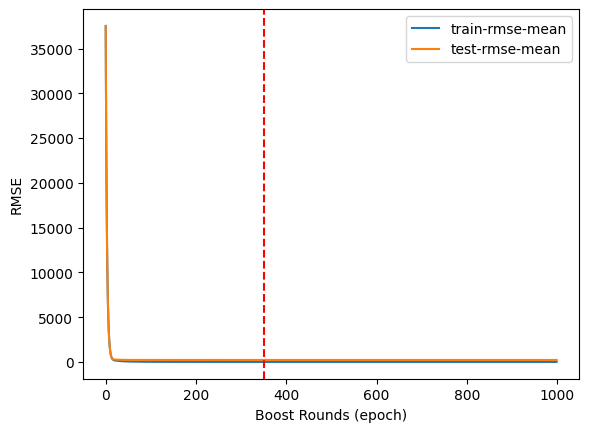

In [64]:
best_rmse = results['test-rmse-mean'].min()
# get index of best rmse
best_idx = results['test-rmse-mean'].idxmin()
# best_idx


#plot rmse
results['train-rmse-mean'].plot()
results['test-rmse-mean'].plot()
# #plot best_idx
plt.axvline(best_idx, c='red', ls='--')
# label
plt.xlabel('Boost Rounds (epoch)')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

preds = model.predict(dtest_reg)
print(X_test.head())
print(preds[:5])

     Sec of Day  Hour  Min  Sec Day of Week To Station  Round        Lat  \
35        46768    12   59   28           2          C      4  14.999973   
876       52883    14   41   23           3          B      8  14.971662   
605       40947    11   22   27           5          C      8  14.998833   
133       58528    16   15   28           2          C     11  14.728821   
281       56535    15   42   15           4          A      3  14.219903   

           Long isStop  Next Lat  Next Long  Abs Distance  
35   121.494844      1      14.5      121.0      0.703452  
876  121.665936      0      15.0      121.5      0.168338  
605  121.465865      1      14.5      121.0      0.682543  
133  121.055432      0      14.5      121.0      0.235439  
281  121.914181      0      14.5      122.0      0.292949  
[47072.098 52944.684 41487.22  58786.895 56777.367]


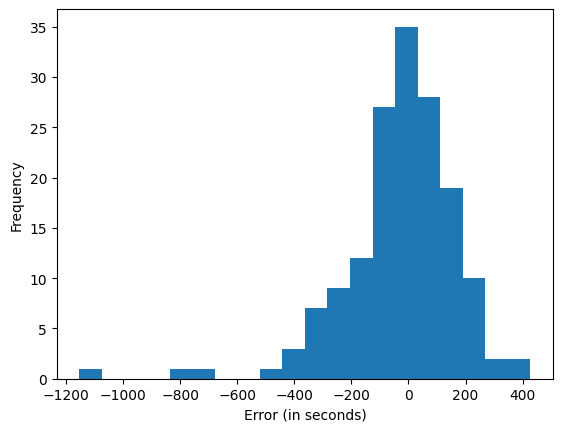

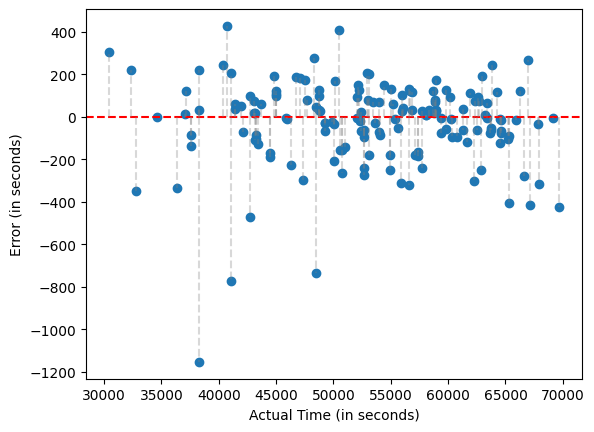

In [66]:
# make difference column for predicted and actual
diff = preds - y_test.values.flatten()

# plot difference distribution graph
plt.hist(diff, bins=20)
plt.xlabel('Error (in seconds)')
plt.ylabel('Frequency')
plt.show()

# plot difference vs actual
plt.scatter(y_test, diff)
plt.xlabel('Actual Time (in seconds)')
plt.ylabel('Error (in seconds)')
#put a horizontal line at 0
plt.axhline(0, c='red', ls='--')
# put a line from the line to each point without using loc
for i in range(len(y_test)):
    # plot a line from the point to the line
      plt.plot([y_test.iloc[i][0], y_test.iloc[i][0]], [0, diff[i]], c='gray', alpha=0.3, ls='--')
plt.show()
# get 5th row of y_tes


In [159]:
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)

print(f"RMSE of the model: {rmse:.3f}")
print(f"MAE of the model: {mae:.3f}")

RMSE of the model: 192.059
MAE of the model: 143.043


In [160]:
# get X_test columns
columns = list(X_test.columns)
columns

['Sec of Day',
 'Hour',
 'Min',
 'Sec',
 'Day of Week',
 'To Station',
 'Round',
 'Lat',
 'Long',
 'isStop',
 'Next Lat',
 'Next Long',
 'Abs Distance']

In [169]:
#['Sec of Day', 'Hour', 'Min', 'Sec', 'Day of Week', 'To Station', 'Round', 'Lat', 'Long', 'isStop', 'Next Lat', 'Next Long', 'Abs Distance']
input = [37809, 10,	30,	9,	4,"B",1,14.83610577,121.8701796,0,15,121.5,0.4048385258]
truth = 38169

input[0] = ((input[1]*60)+input[2])*60+input[3]
input[-1] = np.sqrt((input[7]-input[10])**2+(input[8]-input[11])**2)

print("Input by user:")
for c, i in zip(columns, input):
  print(f"    {c}: {i}")

#convert input to pd dataframe
input = pd.DataFrame([input], columns=['Sec of Day', 'Hour', 'Min', 'Sec', 'Day of Week', 'To Station', 'Round', 'Lat', 'Long', 'isStop', 'Next Lat', 'Next Long', 'Abs Distance'])
# Convert categorical
# print(input)

cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   input[col] = input[col].astype('category')

input['Day of Week'] = input['Day of Week'].astype('category')
input['isStop'] = input['isStop'].astype('category')
input = xgb.DMatrix(input, enable_categorical=True)

y = int(model.predict(input)[0])
time = f"{y//60//60}:{y//60%60:02}:{y%60:02}"
hours = y//60//60
minutes = y//60%60
seconds = y%60
print(f"\nPrediction: {time}")
print(f"\nActual: {truth//60//60}:{truth//60%60:02}:{truth%60:02}")
diff = y-truth
print(f"Difference: {diff//60//60:+}:{diff//60%60:02}:{diff%60:02}")

Input by user:
    Sec of Day: 37809
    Hour: 10
    Min: 30
    Sec: 9
    Day of Week: 4
    To Station: B
    Round: 1
    Lat: 14.83610577
    Long: 121.8701796
    isStop: 0
    Next Lat: 15
    Next Long: 121.5
    Abs Distance: 0.4048385540971279

Prediction: 10:39:35

Actual: 10:36:09
Difference: +0:03:26


In [242]:
# make a difference of X_train['Sec of Day'] and y_train['y']
d = y_train['y'] - X_train['Sec of Day']
# get mean of d
mean = d.mean()
print(f"Average actual travel time: {mean:.02f}")


d_pred = preds - X_test['Sec of Day']
mean_pred = d_pred.mean()
print(f"Average predicted travel time: {mean_pred:.02f}")


Average actual travel time: 264.46
Average predicted travel time: 264.42


# Summary

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

url = ("https://raw.githubusercontent.com/CSfromCS/VHS-Thesis/0a668228516a615aa5ff9c047a1a05a5531d62ea/datatocsv2.csv")
df = pd.read_csv(url, parse_dates=True)
# rename column
df.rename(columns={'Time to Next': 'y'}, inplace=True)
# df.head()

from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = df.drop('y', axis=1), df[['y']]

# Convert categorical
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

X['Day of Week'] = X['Day of Week'].astype('category')
X['isStop'] = X['isStop'].astype('category')

# get dummies
X = pd.get_dummies(X)

# minmax all columns but keep headers
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X[:] = scaler.fit_transform(X)
y[:] = scaler.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Define hyperparameters
params = {"objective": "reg:squarederror"} # , "tree_method": "gpu_hist"}

n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   early_stopping_rounds=20,
)

from sklearn.metrics import mean_squared_error, mean_absolute_error

preds = model.predict(dtest_reg)

rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)

print(f"RMSE of the model: {rmse:.3f}")
print(f"MAE of the model: {mae:.3f}")

[0]	train-rmse:0.17283	validation-rmse:0.16992
[10]	train-rmse:0.00660	validation-rmse:0.00832
[20]	train-rmse:0.00174	validation-rmse:0.00439
[30]	train-rmse:0.00133	validation-rmse:0.00414
[40]	train-rmse:0.00114	validation-rmse:0.00415
[50]	train-rmse:0.00114	validation-rmse:0.00415
[53]	train-rmse:0.00114	validation-rmse:0.00415
RMSE of the model: 0.004
MAE of the model: 0.003


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

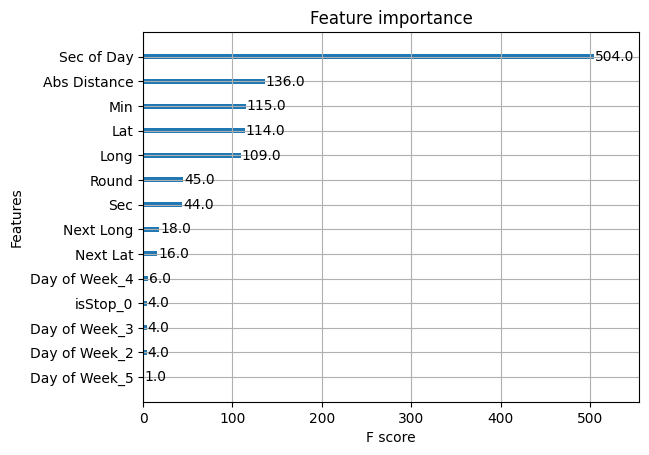

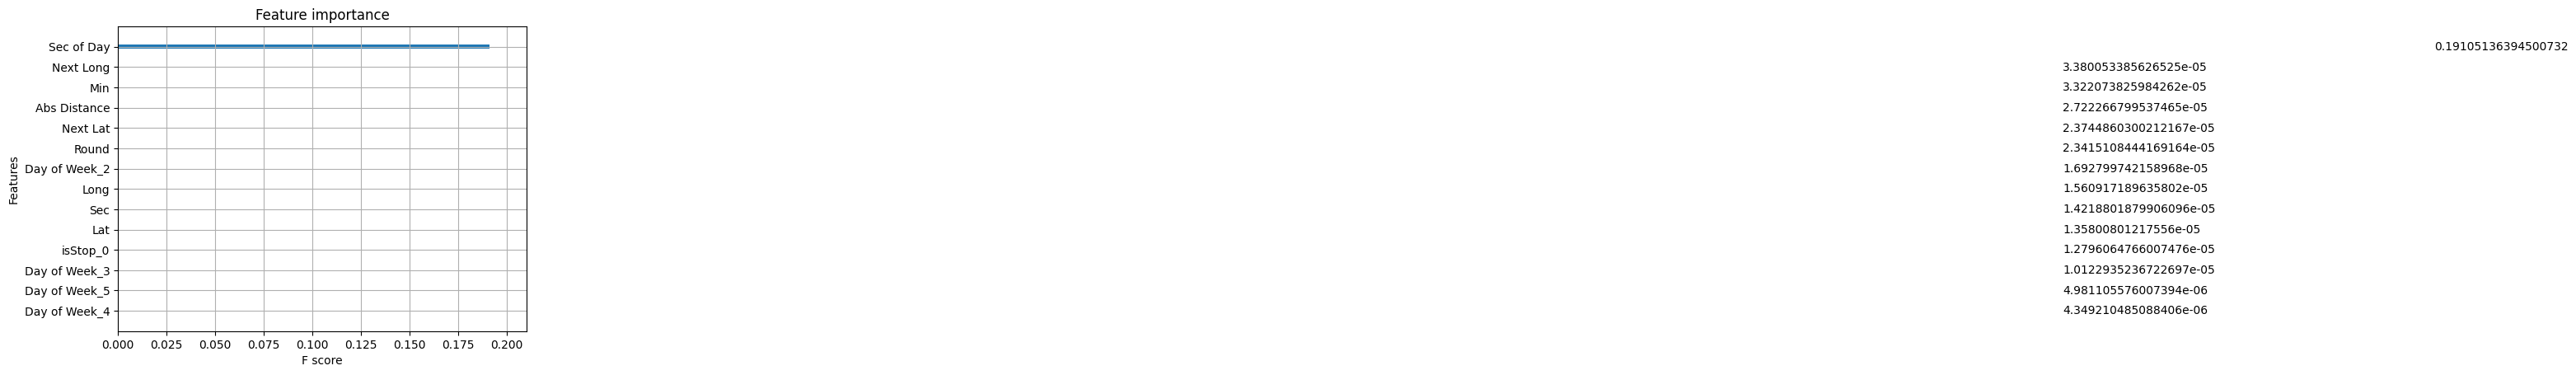

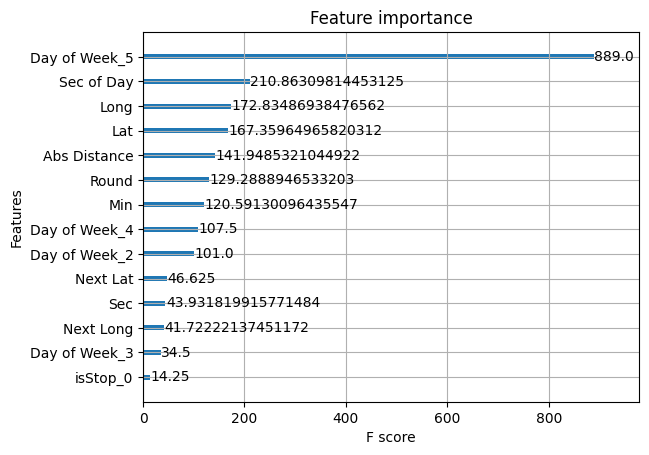

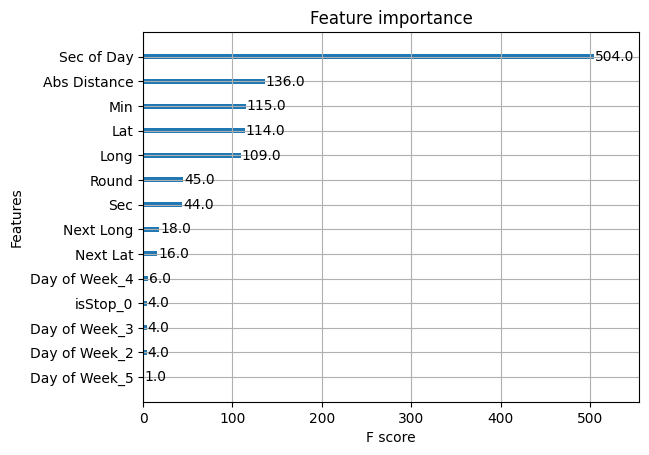

In [10]:
# plot model feature importance
xgb.plot_importance(model)
# all feature importance metrics
xgb.plot_importance(model, importance_type='gain')
xgb.plot_importance(model, importance_type='cover')
xgb.plot_importance(model, importance_type='weight')

## Testing with MinMax and PCA

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

url = ("https://raw.githubusercontent.com/CSfromCS/VHS-Thesis/0a668228516a615aa5ff9c047a1a05a5531d62ea/datatocsv2.csv")
df = pd.read_csv(url, parse_dates=True)
# rename column
df.rename(columns={'Time to Next': 'y'}, inplace=True)
df.head()

from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = df.drop('y', axis=1), df[['y']]


# Convert categorical
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

X['Day of Week'] = X['Day of Week'].astype('category')
X['isStop'] = X['isStop'].astype('category')

# get dummies
X = pd.get_dummies(X)
# X = pd.get_dummies(X, columns=['Day of Week'])


#minmax all columns
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(X)
# y = scaler_y.fit_transform(y)


rmse_scores =[]

for i in range(1,11):

   # Split the data
   X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

   from sklearn.decomposition import PCA

   pca = PCA(n_components=i)

   X_train = pca.fit_transform(X_train)
   X_train = pd.DataFrame(X_train)

   X_test = pca.transform(X_test)
   X_test = pd.DataFrame(X_test)

   import xgboost as xgb

   # Create regression matrices
   dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
   dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

   # Define hyperparameters
   params = {"objective": "reg:squarederror"} # , "tree_method": "gpu_hist"}
   n = 1000
   evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

   model = xgb.train(
      params=params,
      dtrain=dtrain_reg,
      num_boost_round=n,
      evals=evals,
      verbose_eval=False,
      # verbose_eval=10,
      early_stopping_rounds=20,
   )

   from sklearn.metrics import mean_squared_error, mean_absolute_error

   preds = model.predict(dtest_reg)

   rmse = mean_squared_error(y_test, preds, squared=False)
   mae = mean_absolute_error(y_test, preds)

   print(f"RMSE of the model: {rmse:.3f}")
   print(f"MAE of the model: {mae:.3f}")

   rmse_scores.append(rmse)


RMSE of the model: 8411.289
MAE of the model: 6822.360
RMSE of the model: 6969.202
MAE of the model: 5678.043
RMSE of the model: 5758.911
MAE of the model: 4587.111
RMSE of the model: 3215.608
MAE of the model: 2221.452
RMSE of the model: 1339.228
MAE of the model: 983.792
RMSE of the model: 1451.203
MAE of the model: 947.765
RMSE of the model: 1314.187
MAE of the model: 995.220
RMSE of the model: 1269.198
MAE of the model: 895.611
RMSE of the model: 1244.469
MAE of the model: 845.130
RMSE of the model: 1024.965
MAE of the model: 702.903


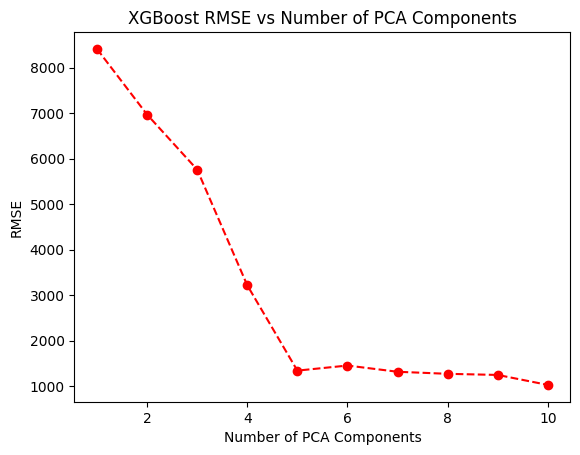

In [32]:
# plot rmse_scores
plt.plot(range(1,11), rmse_scores, marker='o', linestyle='--', color='r')
plt.xlabel('Number of PCA Components')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE vs Number of PCA Components')
plt.show()

In [26]:
# #['Sec of Day', 'Hour', 'Min', 'Sec', 'Day of Week', 'To Station', 'Round', 'Lat', 'Long', 'isStop', 'Next Lat', 'Next Long', 'Abs Distance']
# columns = ['Sec of Day', 'Hour', 'Min', 'Sec', 'Day of Week', 'To Station', 'Round', 'Lat', 'Long', 'isStop', 'Next Lat', 'Next Long', 'Abs Distance']
# input = [37809, 10,	30,	9,	4,"B",1,14.83610577,121.8701796,0,15,121.5,0.4048385258]
# truth = 38169

# input[0] = ((input[1]*60)+input[2])*60+input[3]
# input[-1] = np.sqrt((input[7]-input[10])**2+(input[8]-input[11])**2)

# print("Input by user:")
# for c, i in zip(columns, input):
#   print(f"    {c}: {i}")

# #convert input to pd dataframe
# input = pd.DataFrame([input], columns=['Sec of Day', 'Hour', 'Min', 'Sec', 'Day of Week', 'To Station', 'Round', 'Lat', 'Long', 'isStop', 'Next Lat', 'Next Long', 'Abs Distance'])
# # Convert categorical
# # print(input)

# cats = input.select_dtypes(exclude=np.number).columns.tolist()

# # Convert to Pandas category
# for col in cats:
#    input[col] = input[col].astype('category')

# input['Day of Week'] = input['Day of Week'].astype('category')
# input['isStop'] = input['isStop'].astype('category')

# # get dummies
# # input = pd.get_dummies(input)
# input = pd.get_dummies(input, columns=['Day of Week', 'To Station'])
# print(input.shape)


# #minmax all columns
# # from sklearn.preprocessing import MinMaxScaler
# # scaler_X = MinMaxScaler()
# # scaler_y = MinMaxScaler()
# input[:] = scaler_X.fit_transform(input[:])
# # y = scaler_y.fit_transform(y)


# # pca = PCA(n_components=i)

# # X_train = pca.fit_transform(X_train)
# # X_train = pd.DataFrame(X_train)

# input = pca.transform(input)
# # X_test = pd.DataFrame(X_test)



# input = xgb.DMatrix(input, enable_categorical=True)

# y = int(model.predict(input)[0])
# y = scaler_y.inverse_transform([[y]])[0][0]
# time = f"{y//60//60}:{y//60%60:02}:{y%60:02}"
# hours = y//60//60
# minutes = y//60%60
# seconds = y%60
# print(f"\nPrediction: {time}")
# print(f"\nActual: {truth//60//60}:{truth//60%60:02}:{truth%60:02}")
# diff = y-truth
# print(f"Difference: {diff//60//60:+}:{diff//60%60:02}:{diff%60:02}")

Input by user:
    Sec of Day: 37809
    Hour: 10
    Min: 30
    Sec: 9
    Day of Week: 4
    To Station: B
    Round: 1
    Lat: 14.83610577
    Long: 121.8701796
    isStop: 0
    Next Lat: 15
    Next Long: 121.5
    Abs Distance: 0.4048385540971279
(1, 13)


ValueError: X has 13 features, but PCA is expecting 21 features as input.

# Trying Autoencoder

In [69]:
# support vector regression performance with encoded input
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

url = ("https://raw.githubusercontent.com/CSfromCS/VHS-Thesis/0a668228516a615aa5ff9c047a1a05a5531d62ea/datatocsv2.csv")
df = pd.read_csv(url, parse_dates=True)
# rename column
df.rename(columns={'Time to Next': 'y'}, inplace=True)
df.head()

from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = df.drop('y', axis=1), df[['y']]


# Convert categorical
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

X['Day of Week'] = X['Day of Week'].astype('category')
# X['isStop'] = X['isStop'].astype('category')

# get dummies
X = pd.get_dummies(X)
# X = pd.get_dummies(X, columns=['Day of Week'])


#minmax all columns
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

# reshape target variables so that we can transform them
y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))


# load the model from file
encoder = load_model('encoderv2.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define model
# model = SVR()
# # fit model on the training dataset
# model.fit(X_train_encode, y_train)
# # make prediction on test set
# yhat = model.predict(X_test_encode)


# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train_encode, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test_encode, y_test, enable_categorical=True)

# Define hyperparameters
params = {"objective": "reg:squarederror"} # , "tree_method": "gpu_hist"}
n = 1000
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]


model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=False,
    # verbose_eval=10,
    early_stopping_rounds=20,
)

yhat = model.predict(dtest_reg)

# invert transforms so we can calculate errors
yhat = yhat.reshape((len(yhat), 1))
yhat = scaler_y.inverse_transform(yhat)
y_test = scaler_y.inverse_transform(y_test)
# calculate error
rmse = mean_squared_error(y_test, yhat, squared=True)
score = mean_absolute_error(y_test, yhat)
print(score)

5/5 [==============================] - 0s 484us/step
2427.508504746835


In [70]:
X_train_encode.shape

(889, 10)

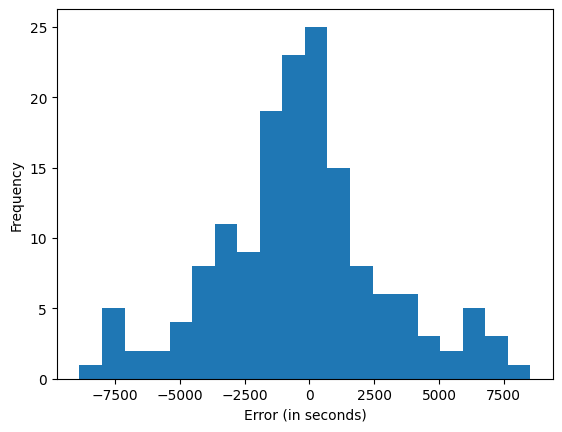

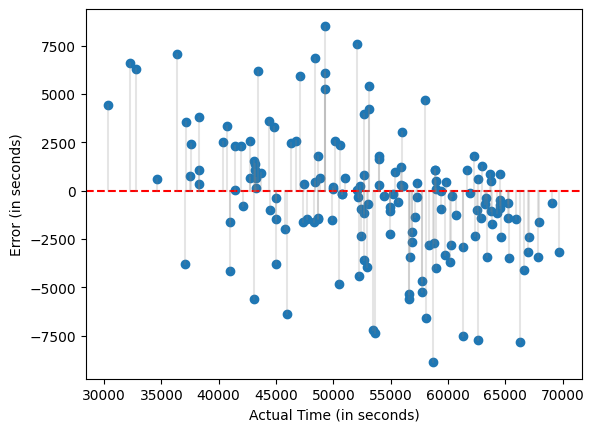

In [71]:
diff = yhat-y_test
# plot scatterplot of diff and y_test

# plot difference distribution graph
plt.hist(diff, bins=20)
plt.xlabel('Error (in seconds)')
plt.ylabel('Frequency')
plt.show()

# plot difference vs actual
plt.scatter(y_test, diff)
plt.xlabel('Actual Time (in seconds)')
plt.ylabel('Error (in seconds)')
#put a horizontal line at 0
plt.axhline(0, c='red', ls='--')
# put a line from the line to each point without using loc

for i in range(len(y_test)):
    # plot a line from the point to the line
    plt.plot([y_test[i], y_test[i]], [0, diff[i][0]], c='grey', alpha=0.2)
plt.show()
# get 5th row of y_tes

